In [374]:
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn

from torch.nn import functional as F
from torch import optim

## 이번에 사용할 데이터는 CIFAR10 데이터셋
테스트 데이터가 따로 존재하지만, 이번에는 학습 데이터만을 사용해보자 

In [375]:
transform_train = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),                            
                                      transforms.RandomCrop(32, padding=4),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(degrees=(-45, 45)),
                                      ])
'''
transforms.RandomCrop(32, padding=4),

                                      transforms.RandomRotation(degrees=(-45, 45)),
                                      
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                        (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(degrees=(-45, 45)),
                                      transforms.RandomHorizontalFlip(p=1),
                                      transforms.RandomVerticalFlip(p=1),
                                      transforms.RandomRotation(degrees=(-45, 45)),

                                      transforms.RandomRotation(degrees=(-45, 45)),
                                      
                                      transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
                                      transforms.ColorJitter(brightness=.5, hue=.3),
                                      transforms.RandomInvert(),
'''

'\ntransforms.RandomCrop(32, padding=4),\n\n                                      transforms.RandomRotation(degrees=(-45, 45)),\n                                      \n                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),\n                                        (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)\n                                      transforms.RandomVerticalFlip(),\n                                      transforms.RandomRotation(degrees=(-45, 45)),\n                                      transforms.RandomHorizontalFlip(p=1),\n                                      transforms.RandomVerticalFlip(p=1),\n                                      transforms.RandomRotation(degrees=(-45, 45)),\n\n                                      transforms.RandomRotation(degrees=(-45, 45)),\n                                      \n                                      transforms.RandomPerspective(distortion_scale=0.6, p=1.0),\n       

In [378]:
train_dataset = datasets.CIFAR100(root = './data', train = True, download = True, transform = transform_train)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data\cifar-100-python.tar.gz to ./data


In [343]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
           )

학습 데이터 중 일부를 모델 평가를 하는데만 사용

In [344]:
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [45000, 5000])

In [345]:
print(len(train_dataset))
print(len(val_dataset))

45000
5000


In [346]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [347]:
for mini_batch in train_loader:
    first_batch = mini_batch
    break

images = first_batch[0]
labels = first_batch[1]

In [348]:
images.shape, labels.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64]))

In [349]:
images[0].shape

torch.Size([3, 32, 32])

이미지를 출력하기 위해 (채널, 높이, 폭) 형태의 데이터를 (높이, 폭, 채널) 형태로 바꿔줘야 한다

In [350]:
# plt.imshow(images[0])
# plt.show()

In [351]:
images[0].numpy().shape

(3, 32, 32)

In [352]:
np.transpose(images[0].numpy(), (1,2,0)).shape

(32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


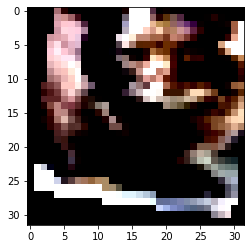

라벨 : cat


In [353]:
plt.imshow(np.transpose(images[0].numpy(), (1,2,0)))
plt.show()
print('라벨 :', classes[labels[0].item()])

Residual connection 을 추가한 모델

In [354]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Root(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1):
        super(Root, self).__init__()
        self.conv = nn.Conv2d(
            in_channels, out_channels, kernel_size,
            stride=1, padding=(kernel_size - 1) // 2, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, xs):
        x = torch.cat(xs, 1)
        out = F.relu(self.bn(self.conv(x)))
        return out


class Tree(nn.Module):
    def __init__(self, block, in_channels, out_channels, level=1, stride=1):
        super(Tree, self).__init__()
        self.level = level
        if level == 1:
            self.root = Root(2*out_channels, out_channels)
            self.left_node = block(in_channels, out_channels, stride=stride)
            self.right_node = block(out_channels, out_channels, stride=1)
        else:
            self.root = Root((level+2)*out_channels, out_channels)
            for i in reversed(range(1, level)):
                subtree = Tree(block, in_channels, out_channels,
                               level=i, stride=stride)
                self.__setattr__('level_%d' % i, subtree)
            self.prev_root = block(in_channels, out_channels, stride=stride)
            self.left_node = block(out_channels, out_channels, stride=1)
            self.right_node = block(out_channels, out_channels, stride=1)

    def forward(self, x):
        xs = [self.prev_root(x)] if self.level > 1 else []
        for i in reversed(range(1, self.level)):
            level_i = self.__getattr__('level_%d' % i)
            x = level_i(x)
            xs.append(x)
        x = self.left_node(x)
        xs.append(x)
        x = self.right_node(x)
        xs.append(x)
        out = self.root(xs)
        return out


class DLA(nn.Module):
    def __init__(self, block=BasicBlock, num_classes=10):
        super(DLA, self).__init__()
        self.base = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Dropout2d(0.2)
        )

        self.layer1 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Dropout2d(0.2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Dropout2d(0.2)
        )

        self.layer3 = Tree(block,  32,  64, level=1, stride=1)
        self.layer4 = Tree(block,  64, 128, level=2, stride=2)
        self.layer5 = Tree(block, 128, 256, level=2, stride=2)
        self.layer6 = Tree(block, 256, 512, level=1, stride=2)
        self.linear = nn.Linear(512, num_classes)

    def forward(self, x):
        out = self.base(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = F.max_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [365]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Root(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1):
        super(Root, self).__init__()
        self.conv = nn.Conv2d(
            in_channels, out_channels, kernel_size,
            stride=1, padding=(kernel_size - 1) // 2, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, xs):
        x = torch.cat(xs, 1)
        out = F.relu(self.bn(self.conv(x)))
        return out


class Tree(nn.Module):
    def __init__(self, block, in_channels, out_channels, level=1, stride=1):
        super(Tree, self).__init__()
        self.level = level
        if level == 1:
            self.root = Root(2*out_channels, out_channels)
            self.left_node = block(in_channels, out_channels, stride=stride)
            self.right_node = block(out_channels, out_channels, stride=1)
        else:
            self.root = Root((level+2)*out_channels, out_channels)
            for i in reversed(range(1, level)):
                subtree = Tree(block, in_channels, out_channels,
                               level=i, stride=stride)
                self.__setattr__('level_%d' % i, subtree)
            self.prev_root = block(in_channels, out_channels, stride=stride)
            self.left_node = block(out_channels, out_channels, stride=1)
            self.right_node = block(out_channels, out_channels, stride=1)

    def forward(self, x):
        xs = [self.prev_root(x)] if self.level > 1 else []
        for i in reversed(range(1, self.level)):
            level_i = self.__getattr__('level_%d' % i)
            x = level_i(x)
            xs.append(x)
        x = self.left_node(x)
        xs.append(x)
        x = self.right_node(x)
        xs.append(x)
        out = self.root(xs)
        return out


class DLA_fc(nn.Module):
    def __init__(self, block=BasicBlock, num_classes=10):
        super(DLA_fc, self).__init__()
        self.base = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Dropout2d(0.3)
        )

        self.layer1 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Dropout2d(0.3)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Dropout2d(0.3)
        )

        self.layer3 = Tree(block,  32,  64, level=1, stride=1)
        self.layer4 = Tree(block,  64, 128, level=2, stride=2)
        self.layer5 = Tree(block, 128, 256, level=2, stride=2)
        self.layer6 = Tree(block, 256, 512, level=1, stride=2)
        self.linear1 = nn.Linear(512, 256)
        self.linear2 = nn.Linear(256, 128)
        self.linear3 = nn.Linear(128, num_classes)
        
        self.drop1 = nn.Dropout2d(p=0.5)  
        self.drop2 = nn.Dropout2d(p=0.5)  

    def forward(self, x):
        out = self.base(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = F.max_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.drop1(F.relu(self.linear1(out)))
        out = self.drop2(F.relu(self.linear2(out)))
        out = self.linear3(out)
        return out

모델 출력값이 원하는 모양인지 확인

In [366]:
model = DLA_fc().to(device)

In [367]:
model(torch.rand(1,3,32, 32).to(device)).shape

torch.Size([1, 10])

In [368]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

16451770


In [369]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005) # .0.1 momentum=0.9, weight_decay=0.0005
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=lambda epoch: 0.95 ** epoch)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
#ReduceLROnPlateau(optimizer, patience=5, mode='min', verbose=1)
#CosineAnnealingLR(optimizer, T_max=300)       lr 0.1  0.95   epoch 300

In [370]:
def train():
    model.train()
    start_time = time.time()
    train_loss = 0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predicted = torch.argmax(outputs, dim = 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    end_time = time.time()

    return train_loss/len(train_loader), 100*correct / total, end_time - start_time

In [371]:
def validation():
    model.eval()
    start_time = time.time()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_func(outputs, labels)

            val_loss += loss.item()
            predicted = torch.argmax(outputs, dim = 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    end_time = time.time()

    return val_loss/len(val_loader), 100*correct / total, end_time - start_time

학습 하는 중간중간에 평가용 데이터셋에서의 성능을 확인

In [372]:
!nvidia-smi

Sat Oct 30 15:34:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 471.68       Driver Version: 471.68       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   65C    P0    29W /  N/A |   5763MiB /  6144MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [373]:
epochs = 200
max_val_acc = 0

train_losses = []
val_losses = []
train_acces = []
val_acces = []


for epoch in range(epochs):
    train_loss, train_acc, train_time = train()
    print('Epoch : {}, Train loss : {}, acc : {}, time : {}'.format(epoch + 1, train_loss, train_acc, train_time))
    train_losses.append(train_loss)
    train_acces.append(train_acc)
    
    val_loss, val_acc, val_time = validation()
    print('      Validation loss : {}, acc : {}, time : {}'.format(val_loss, val_acc, val_time))
    val_losses.append(val_loss)
    val_acces.append(val_acc)
    
    scheduler.step()
    
    if val_acc >= max_val_acc: # 가장 평가 성능이 좋은 모델을 저장
        PATH = f'./model/DLA_FC_{val_acc}.pth'
        torch.save(model.state_dict(), PATH)
        max_val_acc = val_acc

Epoch : 1, Train loss : 2.2138157707046378, acc : 15.377777777777778, time : 148.79685735702515
      Validation loss : 2.0002628640283513, acc : 21.8, time : 7.019394636154175
Epoch : 2, Train loss : 2.0009702137586745, acc : 23.622222222222224, time : 149.10124015808105
      Validation loss : 1.8615649500979652, acc : 31.18, time : 6.991394281387329
Epoch : 3, Train loss : 1.9111995177174157, acc : 27.84, time : 148.76149916648865
      Validation loss : 1.784643690797347, acc : 34.0, time : 6.432776927947998
Epoch : 4, Train loss : 1.8103343099355698, acc : 32.6, time : 160.89109349250793
      Validation loss : 1.7174070485030548, acc : 35.56, time : 7.569172143936157
Epoch : 5, Train loss : 1.7364050195637075, acc : 35.82888888888889, time : 152.62418961524963
      Validation loss : 1.6211988005457045, acc : 40.4, time : 7.068498373031616
Epoch : 6, Train loss : 1.6513015263798563, acc : 39.60444444444445, time : 150.20970559120178
      Validation loss : 1.544929507412488, acc 

KeyboardInterrupt: 

In [118]:
PATH = f'./model/Last_epoch_{val_acc}.pth'
torch.save(model.state_dict(), PATH)

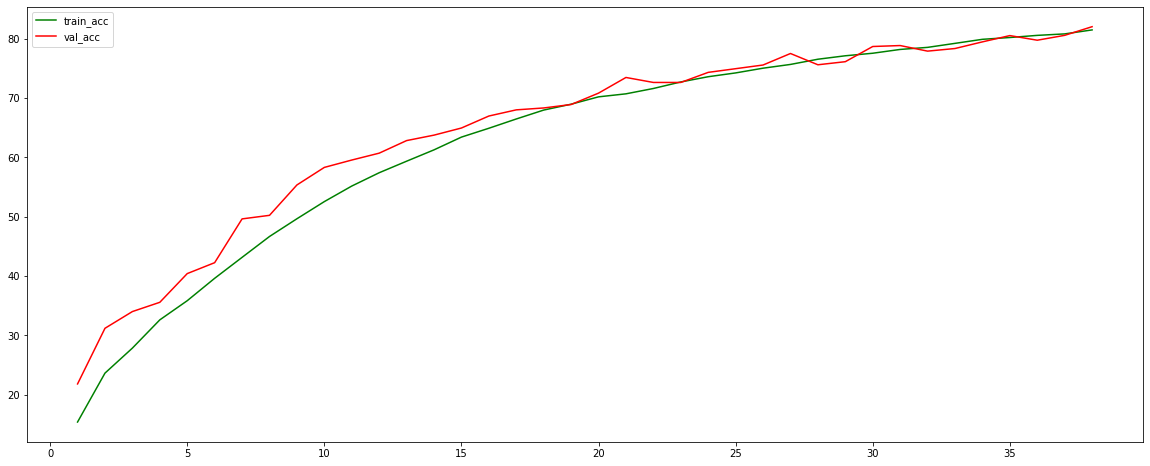

<Figure size 432x288 with 0 Axes>

In [379]:
plt.plot(range(1, len(train_acces) + 1), train_acces, c = 'g', label='train_acc')
plt.legend()
plt.plot(range(1, len(val_acces) + 1), val_acces, c = 'r', label='val_acc')
plt.legend()
plt.show()
plt.savefig('acc.png')
# print(len(train_acces))

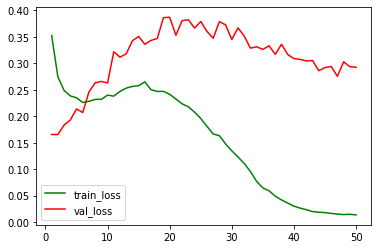

In [117]:
plt.plot(range(1, len(train_acces) + 1), train_losses, c = 'g', label='train_loss')
plt.legend()
plt.plot(range(1, len(train_acces) + 1), val_losses, c = 'r', label='val_loss')
plt.legend()
plt.show() 
plt.savefig('loss.png')

## 모델 성능 확인

In [213]:
PATH = "./model/DLA_FC93.83.pth"
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [214]:
for mini_batch in val_loader:
    first_batch = mini_batch
    break

inputs = first_batch[0]
labels = first_batch[1]
model.eval()
outputs = model(inputs.to(device))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


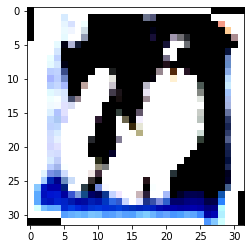

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


예측 : dog
라벨 : dog


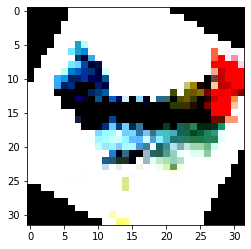

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


예측 : plane
라벨 : bird


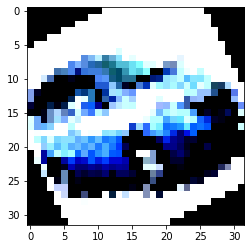

예측 : frog
라벨 : car


In [215]:
for i in range(3): 
    sample_number = i

    plt.imshow(np.transpose(inputs[sample_number].numpy(), (1,2,0)))
    plt.show()
    print('예측 :', classes[torch.argmax(outputs[sample_number]).item()])
    print('라벨 :', classes[labels[sample_number].item()])

In [230]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
test_dataset = datasets.CIFAR10(root = './data./test', train = False, download = True, transform = transform_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Files already downloaded and verified


In [231]:
for mini_batch in test_loader:
    first_batch = mini_batch
    break

inputs = first_batch[0]
labels = first_batch[1]
model.eval()
outputs = model(inputs.to(device))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


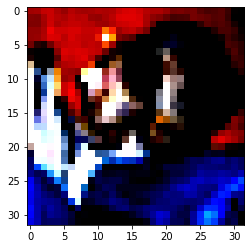

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


예측 : cat
라벨 : cat


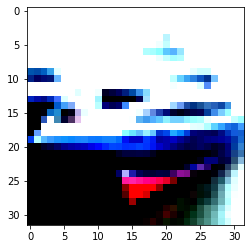

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


예측 : ship
라벨 : ship


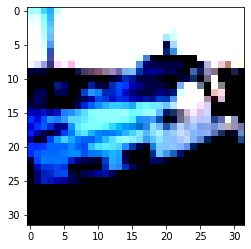

예측 : ship
라벨 : ship


In [232]:
for i in range(3): 
    sample_number = i

    plt.imshow(np.transpose(inputs[sample_number].numpy(), (1,2,0)))
    plt.show()
    print('예측 :', classes[torch.argmax(outputs[sample_number]).item()])
    print('라벨 :', classes[labels[sample_number].item()])

In [233]:
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        predicted = torch.argmax(outputs, dim = 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(total)
    print(100*correct / total)

10000
93.83
